# Relating floe size / grid size ratio and object uncertainty

* The size of the object vs the size of the grid determines whether something is low, medium, or high resolution
* FSD varies from far below image resolution to 10s of km, so for the context of FSD MODIS can be low to high resolution

## Discretization error
Consider a circle with radius $r$ centered at $x, y$. We can directly calculate the circumference and the area. We approximate visualizing the object with a grid of size $\Delta x$ by selecting all grid cells whose centers are at or within the circle boundary.

* Error in estimated position: centroid - $(x, y)$
* Error in estimated perimeter: perimeter - 2$\pi r$
* Error in estimated area: area

## Questions
* How big does a floe need to be in comparison to the grid for us to have confidence in the area?
* How about for the orientation? (e.g., can we accurately estimate the rotation between images?)


## Thoughts
Taking notes from lecture notes: https://www2.it.uu.se/edu/course/homepage/bild2/v16/schedule/Coverage_CAIA2016.pdf 

Rather than looking at a distribution for each shape, let us look at the full set of possible crisp discrete representations. Determining the error exactly is related to Gauss's circle problem

In [9]:
import proplot as pplt
import numpy as np
import skimage 
import pandas as pd

def in_circle(x_loc, y_loc, x_circle, y_circle, r_circle):
    """Checks if the position x_loc, y_loc is inside a circle with radius r_circle
    centered at x_circle, y_circle."""
    return np.sqrt((x_loc - x_circle)**2 + (y_loc - y_circle)**2) < r_circle

def draw_circle(x, y, r, n=201):

    X = np.linspace(-r, r, n)
    yp = np.sqrt(r**2 - X**2)
    ym = -np.sqrt(r**2 - X**2)
    Y = np.hstack([yp, ym]) + y
    X = np.hstack([X, X[::-1]]) + x
    return X, Y

def circle_approx(x_centers, y_centers, x_circle, y_circle, r_circle):
    """Approximates a circle on a discrete grid by checking if the grid cell center
    is inside the circle."""
    
    return np.reshape(in_circle(np.ravel(x_centers),
                                np.ravel(y_centers),
                                x_circle, y_circle,
                                r_circle), x_centers.shape)
    


# Example image
To demonstrate the issue with binarization, we look at a circle with radius 3 (in pixel units). Since the shape is radially symmetric, we look at the variation in shapes possible from perturbations of position into the upper right quadrant. Perturbations into the other three quadrants would be identical to these shapes under rotation. We find 32 possibilities, which includes a few that are rotations of the other shapes. 

The red circle shows the true shape, while the black boxes show the pixels whose centers are inside the circle (Gauss digitization). The true perimeter is 18.85 pixels, and the true area is 28.27 pixels squared. Next, we computed the area of the circle centered on evenly spaced points from -0.5 to 0.5 in both x and y, spaced 0.01 pixels apart. The mean (min, max) of the measured variables were
* Perimeter: 16.98 (15.66, 17.66)
* Area: 28 (25, 32)
Thus, every estimate of the perimeter at this radius size was an underestimate, while the mean area was close to the true value and the min-max range included the true value.


3 32


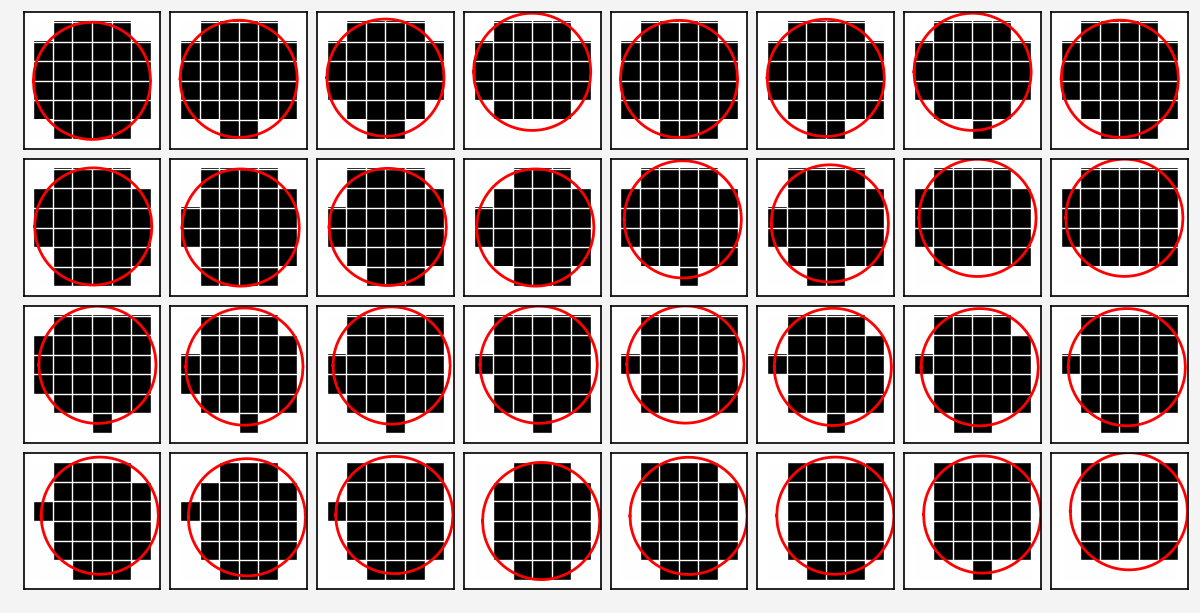

In [49]:
unique = True
for r in [3]: # Circle radius
    n = int(2*np.ceil(r) + 1) # Box dimensions - should be odd, so that the center can be 0
    A = np.ones((n, n))
    X, Y = np.meshgrid(np.linspace(-(n-1)/2, (n-1)/2, n),
                       np.linspace(-(n-1)/2, (n-1)/2, n))
    
    XC = (X[1:, 1:] + X[1:, :-1])*0.5
    YC = (Y[1:, :-1] + Y[:-1, :-1])*0.5
    
    # Get the unique shapes based on deviations in the origin
    possible_shapes = []
    xy_loc = []
    for x in np.linspace(0, 0.5, 100):
        for y in np.linspace(0, 0.5, 100):
            p = ','.join([str(x) for x in np.ravel(circle_approx(XC, YC, x, y, r).astype(int))])

            if unique:
                if p not in possible_shapes:
                    possible_shapes.append(p)
                    xy_loc.append([x, y])
            else:
                possible_shapes.append(p)
                xy_loc.append([x, y])
                
    print(r, len(possible_shapes))
    
fig, axs = pplt.subplots(ncols=8, nrows=4, width=6, hspace=0.4, wspace=0.4)
for ax, p, xy in zip(axs, possible_shapes, xy_loc):
    P = np.reshape(np.array(p.split(',')).astype(int), XC.shape)
    x, y = xy
    ax.imshow(P, cmap='mono', vmin=0, vmax=1, extent=[-(n-1)/2, (n-1)/2, (n-1)/2, -(n-1)/2]) 
    ax.format(xlocator='null', ylocator='null')
    xc, yc = draw_circle(x=x, y=y, r=r)
    
    for ii in np.linspace(-(n-1)/2, (n-1)/2, n):
        ax.axhline(ii, color='w', lw=0.5)
        ax.axvline(ii, color='w', lw=0.5)
    ax.plot(xc, yc, color='r', lw=1)        
axs.format(ylim=(-n/2, n/2),
           xlim=(-n/2, n/2))

In [34]:
shape_stats = []
for p, xy in zip(possible_shapes, xy_loc):
    P = np.reshape(np.array(p.split(',')).astype(int), XC.shape)
    rp = skimage.measure.regionprops(P)[0]
    cent_x = XC[0,0] + rp.centroid[1]
    cent_y = YC[0,0] + rp.centroid[0]
    shape_stats.append([rp.area, rp.perimeter, cent_x, cent_y, xy[0], xy[1]])
shape_stats = pd.DataFrame(shape_stats, columns=['area', 'perimeter', 'centroid_x', 'centroid_y', 'x0', 'y0'])
shape_stats['d'] = np.sqrt((shape_stats['x0'] - shape_stats['centroid_x'])**2 + (shape_stats['y0'] - shape_stats['centroid_y'])**2)

In [54]:
pd.concat([shape_stats.mean(),shape_stats.min(), shape_stats.max()],axis=1)

,0,1,2
area,28.000000,25.000000,32.000000
perimeter,16.976937,15.656854,17.656854
centroid_x,0.235265,0.000000,0.500000
centroid_y,0.235265,0.000000,0.500000
x0,0.245265,0.000000,0.500000
y0,0.275410,0.000000,0.500000
d,0.096857,0.000000,0.186512


In [50]:
print("Perimeter", 2*np.pi*r)
print("Area", np.pi*r**2)

Perimeter 18.84955592153876
Area 28.274333882308138


# Experiment 1: Circles with varying radii
For the context of ice floes, we consider circles with radius ranging from 2 pixels up to 25 pixels. In MODIS imagery, with pixels of 250 m, this is equivalent to circular floe areas of 0.79 km$^2$ to 122.7 km$^2$. For each radius, we carry out the same uniform sampling of a 1-pixel region. This non-random sampling scheme represents the assumtion that any floe centroid position within a pixel is equally likely.

In [163]:
%%time
shape_stats = []
for r in np.arange(2, 100): # Circle radius
    n = int(2*np.ceil(r) + 1) # Box dimensions - should be odd, so that the center can be 0
    A = np.ones((n, n))
    X, Y = np.meshgrid(np.linspace(-(n-1)/2, (n-1)/2, n),
                       np.linspace(-(n-1)/2, (n-1)/2, n))
    
    XC = (X[1:, 1:] + X[1:, :-1])*0.5
    YC = (Y[1:, :-1] + Y[:-1, :-1])*0.5
    
    # Get the unique shapes based on deviations in the origin
    possible_shapes = []
    xy_loc = []
    
    # Increments of 0.01 pixel, covering a 1 by 1 pixel uniformly
    for x in np.linspace(-0.5, 0.5, 101): # Testing with smaller set
        for y in np.linspace(-0.5, 0.5, 101):
            P = circle_approx(XC, YC, x, y, r).astype(int)
      
            rp = skimage.measure.regionprops(P)[0]
            cent_x = XC[0,0] + rp.centroid[1]
            cent_y = YC[0,0] + rp.centroid[0]
            shape_stats.append([r,  x, y, cent_x, cent_y, rp.perimeter,  rp.area, rp.area_convex, rp.orientation])

shape_stats = pd.DataFrame(shape_stats, columns=['r', 'x', 'y', 'centroid_x', 'centroid_y', 
                                                 'perimeter', 'area', 'area_convex', 'orientation'])


KeyboardInterrupt: 

In [164]:
shape_stats = pd.DataFrame(shape_stats, columns=['r', 'x', 'y', 'centroid_x', 'centroid_y', 
                                                 'perimeter', 'area', 'area_convex', 'orientation'])


In [167]:
shape_stats['area_true'] = np.pi*shape_stats['r']**2
shape_stats['perimeter_true'] = 2*np.pi*shape_stats['r']
shape_stats['area_error'] = shape_stats['area'] - shape_stats['area_true']
shape_stats['perimeter_error'] = shape_stats['perimeter'] - shape_stats['perimeter_true']
shape_stats['d'] = np.sqrt((shape_stats['centroid_x'] - shape_stats['x'])**2 + \
                           (shape_stats['centroid_y'] - shape_stats['y'])**2)
ss_mean = shape_stats.groupby('r').mean()
ss_stdev = shape_stats.groupby('r').std()
ss_med = shape_stats.groupby('r').median()
ss_p99 = shape_stats.groupby('r').quantile(0.99)
ss_p01 = shape_stats.groupby('r').quantile(0.01)
ss_p75 = shape_stats.groupby('r').quantile(0.75)
ss_p25 = shape_stats.groupby('r').quantile(0.25)

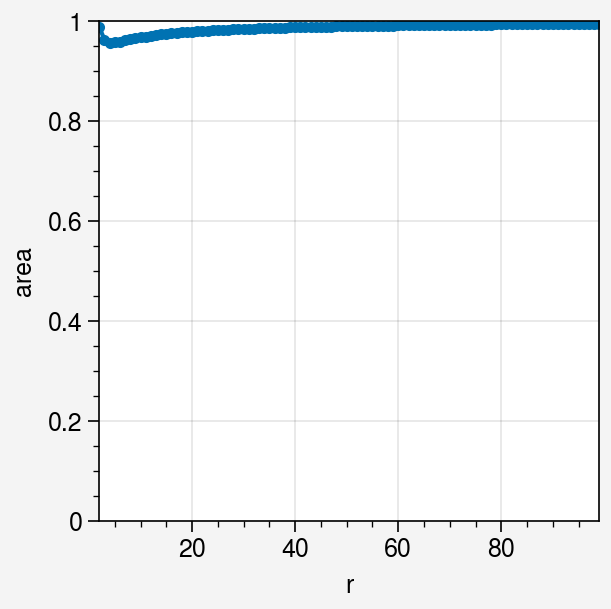

In [168]:
fig, ax = pplt.subplots()
ax.plot(ss_mean.area/ss_mean.area_convex.values, marker='.')
ax.format(ylim=(0, 1))

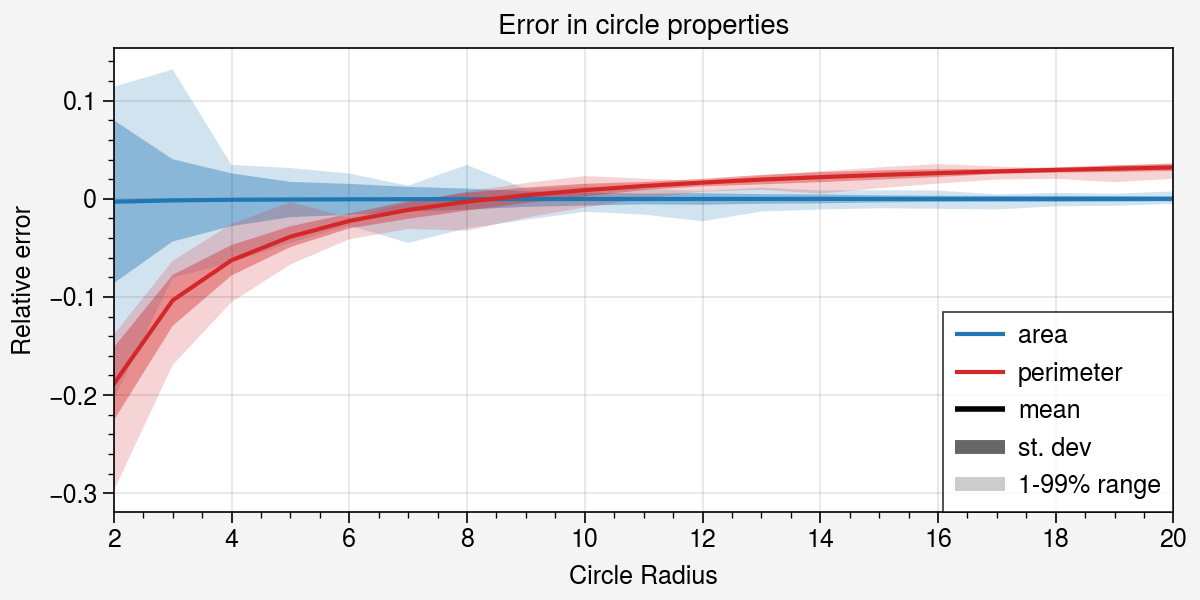

In [215]:
fig, ax = pplt.subplots(width=6, height=3)
for measure, color in zip(['area', 'perimeter'], ['tab:blue', 'tab:red']):
    ax.plot(ss_med.index, ss_mean[measure + '_error']/ss_mean[measure + '_true'],
            shadedata=ss_stdev[measure + '_error']/ss_mean[measure + '_true'], # ss_p25[measure + '_error']/ss_med[measure + '_true']],
            fadedata=[ss_p99[measure + '_error']/ss_mean[measure + '_true'], ss_p01[measure + '_error']/ss_mean[measure + '_true']],
            label=measure, marker='', color=color)
ax.plot([],[], lw=2, alpha=1, color='k', label='mean')
ax.plot([],[], lw=5, alpha=0.6, color='k', label='st. dev')
ax.plot([],[], lw=5, alpha=0.2, color='k', label='1-99% range')
ax.format(xlabel='Circle Radius', ylabel='Relative error', title='Error in circle properties', xlim=(2, 20))
ax.legend(loc='lr', ncols=1)

In [217]:
np.sqrt(100/np.pi), np.sqrt(300/np.pi), np.sqrt(1200/np.pi), 

(5.641895835477563, 9.772050238058398, 19.544100476116796)

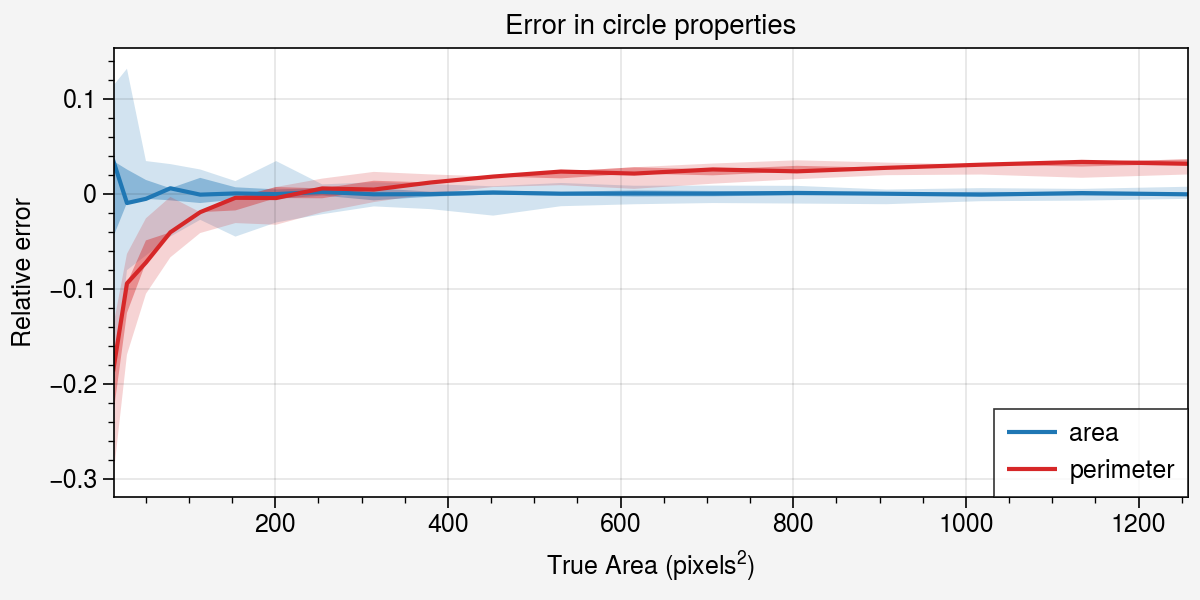

In [201]:
fig, ax = pplt.subplots(width=6, height=3)
for measure, color in zip(['area', 'perimeter'], ['tab:blue', 'tab:red']):
    ax.plot(ss_med.area_true.values, ss_med[measure + '_error']/ss_med[measure + '_true'],
            shadedata=[ss_p75[measure + '_error']/ss_med[measure + '_true'], ss_p25[measure + '_error']/ss_med[measure + '_true']],
            fadedata=[ss_p99[measure + '_error']/ss_med[measure + '_true'], ss_p01[measure + '_error']/ss_med[measure + '_true']],
            label=measure, marker='', color=color)

ax.format(xlabel='True Area (pixels$^2$)', ylabel='Relative error', title='Error in circle properties', xlim=(13, np.pi*20**2))
ax.legend(loc='lr', ncols=1)

In [202]:
np.sqrt(300/np.pi)

9.772050238058398

This isn't quite the right math but it's sketching out the idea. What it should show in the end is based on the PDF of the estimates, we want to find the radius where we are 95% confidence that the area has relative error of 5% or less, and the radius where we are confident the relative error is 1% or less. Those should be the cutoffs for small floe and for large floe. Interestingly my back-of-the envelope method has the small floe cutoff around 250 and large floe around 1660, similar to the defaults used earlier of 300 and 1200.

In [228]:
err_thresh = 0.025
emax = pd.DataFrame({'p99': np.abs(ss_p99['area_error']/ss_mean['area_true']),
              'p11': np.abs(ss_p01['area_error']/ss_mean['area_true'])}).max(axis=1)
print('Minimum for 10% error r=', emax[emax < 0.05].index.min())
print('Minimum for 5% error r=', emax[emax < 0.025].index.min())
print('Minimum for 1% error r=', emax[emax < 0.005].index.min())

Minimum for 10% error r= 5
Minimum for 5% error r= 9
Minimum for 1% error r= 23


In [191]:
np.pi*9**2, np.pi*23**2

(254.46900494077323, 1661.9025137490005)

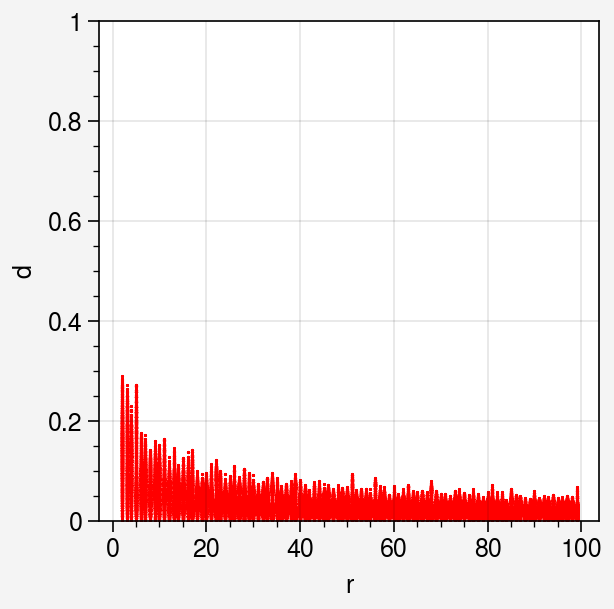

In [173]:
fig, ax = pplt.subplots()
ax.scatter(shape_stats['r'], shape_stats['d'], ms=1, m='.', color='r')#, shadedata=ss_stdev['d'])
ax.format(ylim=(0, 1))
# ax2 = ax.twinx()
# ax2.scatter(shape_stats['r'], shape_stats['orientation'], ms=1, m='.')

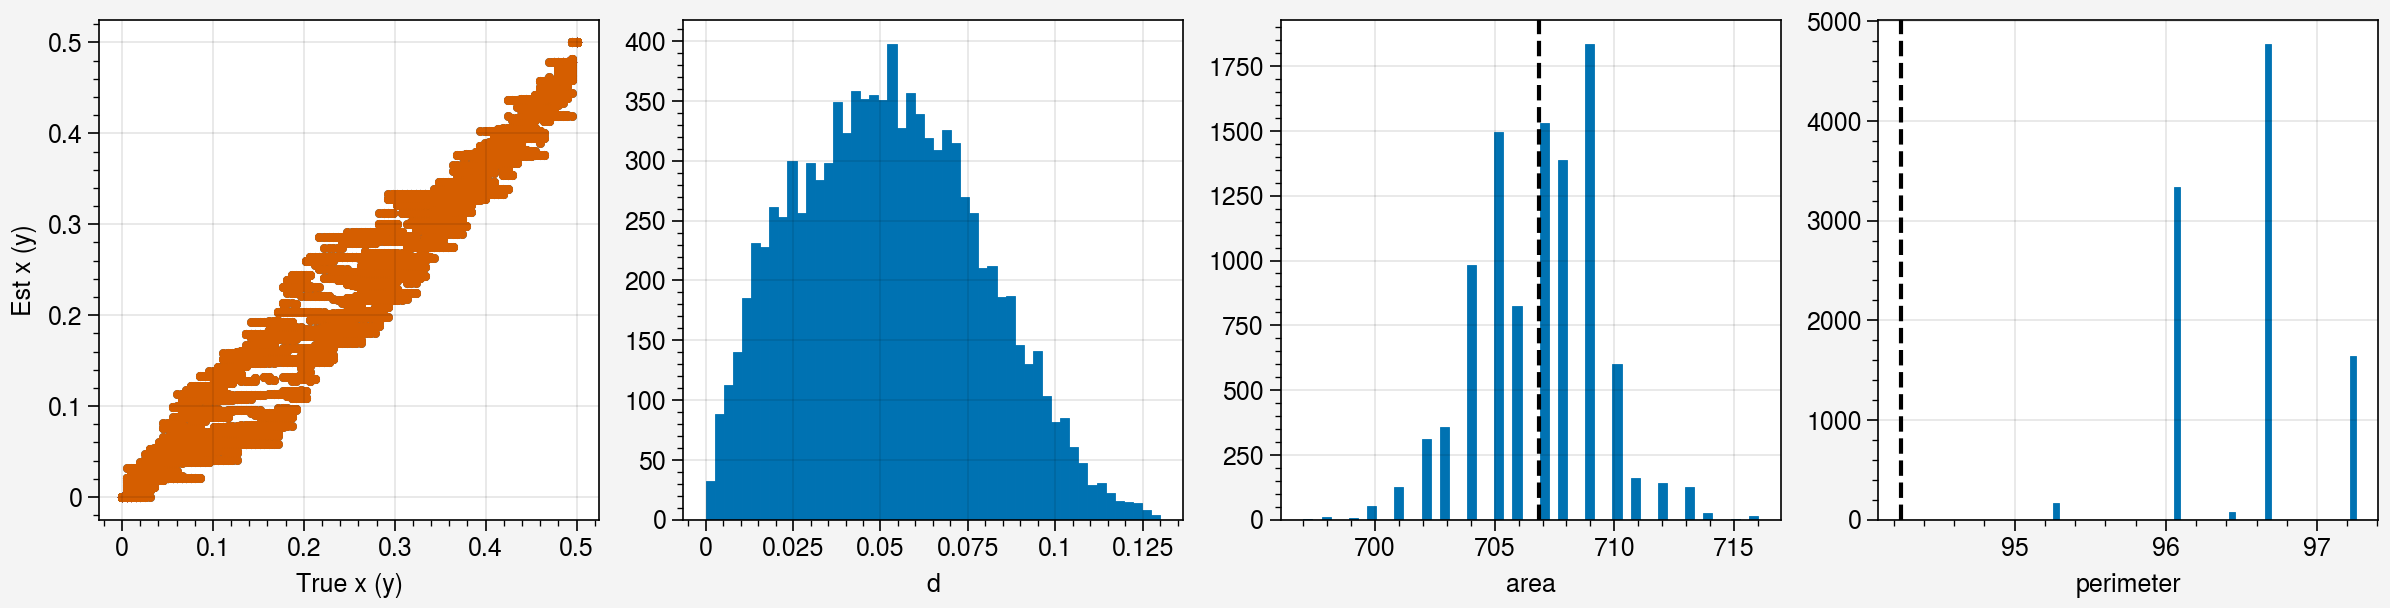

In [25]:
fig, ax = pplt.subplots(ncols=4, share=False)
ax[0].scatter(shape_stats['x0'], shape_stats['centroid_x'], ms=7)
ax[0].scatter(shape_stats['y0'], shape_stats['centroid_y'], ms=7)
ax[0].format(xlabel='True x (y)', ylabel='Est x (y)')
ax[1].hist(shape_stats['d'], bins=50)
# ax[1].axvline(0, color='k', ls='--')
ax[2].hist(shape_stats['area'], bins=50)
ax[2].axvline(np.pi*r**2, color='k', ls='--')
ax[3].hist(shape_stats['perimeter'], bins=50)
ax[3].axvline(2*np.pi*r, color='k', ls='--')

Some initial observations (circle with r = 5):
- The correlation with est and true x and y shows bias that switches at about halfway across a grid cell. The distance has two modes.
- Area could be approximated with a normal dist, probably. Standard deviation is 1.37.
- Perimeter has distinct low bias (will affect est. of circularity)

With radius 10, the perimeter is biased high. Less of a spread with the x/y. Closer to unimodal d distribution. Area dist is bimodal, standard deviation 2.04.

- Plan: calculate the uncertainty properties as a function of r for radius sizes 1 to the largest ice floes we expect to find, something like radius 50 km. Show the mean and variance for each measure.

For the next steps, rectangle and ellipse shapes, we'll get the orientation and the eccentricity.


In [30]:
shape_stats.mean()

area          706.822200
perimeter      96.544740
centroid_x      0.223778
centroid_y      0.223778
x0              0.250000
y0              0.250000
d               0.052353
dtype: float64

In [293]:
# Working with a 20 by 20 grid
# Unitless - looking at relationship between grid dimension and radius.
# Start with circle of n = 2

import pandas as pd
error_results = []
for r in [29]:
    for ii in range(10000):
        x, y = rng.random(2) - 0.5
        rp = skimage.measure.regionprops(circle_approx(XC, YC, x, y, r).astype(int))[0]
        err_area = rp.area - np.pi*r**2
        err_perimeter = rp.perimeter - 2*np.pi*r
        cent_x, cent_y = rp.centroid # Provides the location in **indices**, convert based on location of center (n / 2)
        cent_x = XC[0,0] + cent_x
        cent_y = YC[0,0] + cent_y
        err_location = np.sqrt((x - cent_x)**2 + (y-cent_y)**2)
        error_results.append([r,  err_location, rp.area, err_area, err_perimeter])
error_results = pd.DataFrame(error_results, columns=['radius', 'loc_error', 'area_est', 'area_error', 'perim_error'])

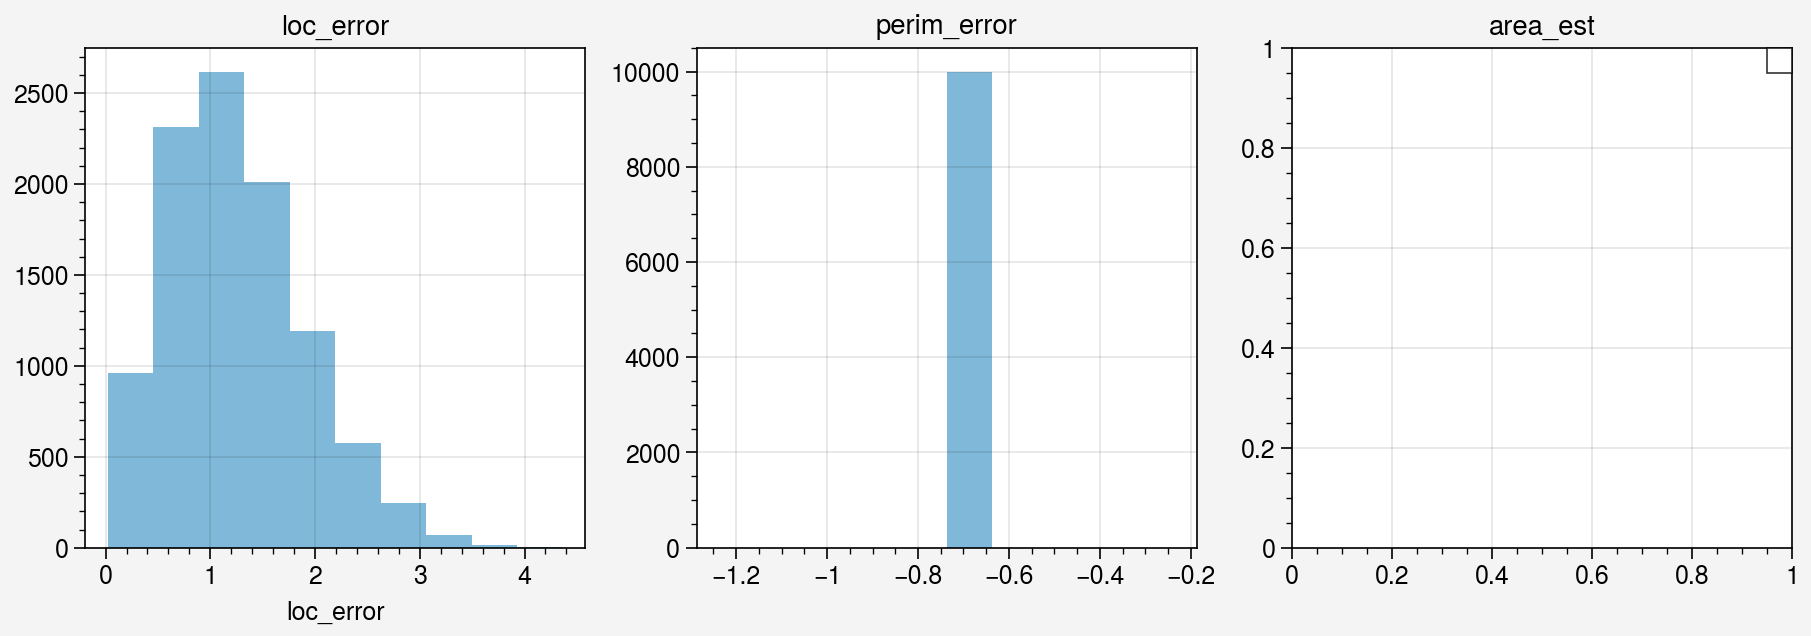

In [294]:
fig, axs = pplt.subplots(ncols=3, share=False)
for r, group in error_results.groupby('radius'):
    for ax, errtype in zip(axs, ['loc_error', 'perim_error',  'area_est']):
        if errtype == 'loc_error':
            ax.hist(group[errtype], alpha=0.5, label=r)
        elif errtype == 'perim_error':
            ax.hist(group[errtype]/(2*np.pi*group['radius']), alpha=0.5, label=r)
        elif errtype == 'area_error':
            ax.hist(group[errtype]/(np.pi*group['radius']**2), alpha=0.5, label=r, bins=np.linspace(0, 1, 100))
        ax.format(title=errtype)
    ax.legend(loc='ur', ncols=1)
# axs[-1].axvline(np.pi*r**2)

In [296]:
np.mean(group[errtype]/(np.pi*group['radius']**2))

0.06396476904287828

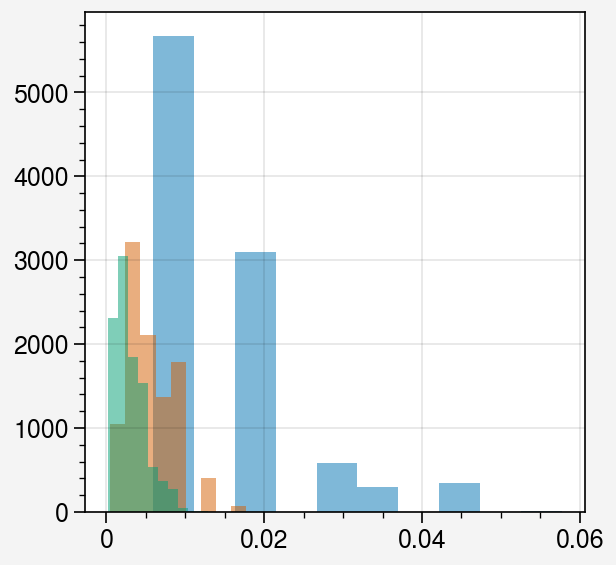

In [249]:
fig, ax = pplt.subplots()
for r, group in (error_results['area_error']/(np.pi*error_results['radius']**2)).groupby(error_results['radius']):
    ax.hist(np.abs(group), alpha=0.5)

# Relating to Gauss's bound on the circle problem
If we define an acceptable relative error as $\epsilon$,
then based on Gauss's bound to the number of lattice points contained in a circle, 
$$N(r) \leq \pi r^2 + 2 \sqrt{2} \pi r$$
then we can estimate the minimum circle radius as the smallest $r$ such that
$$ \frac{\pi r^2 - N(r)}{\pi r^2} = \frac{2 \sqrt{2} \pi r}{\pi r^2} = \frac{2 \sqrt{2}}{r} \leq \epsilon  $$
so that 
$$ r \geq 2 \sqrt{2} / \epsilon $$

In [ ]:
Relative area error = pi r2 - N(r) / pi r2

In [223]:
ss_mean['area_true'] - ss_mean['area']

r
2     0.037795
3     0.046905
4     0.051190
5     0.060844
6     0.064888
        ...   
95    0.259249
96    0.246589
97    0.282431
98    0.236984
99   -0.141783
Length: 98, dtype: float64

<a list of 1 Line2D objects>

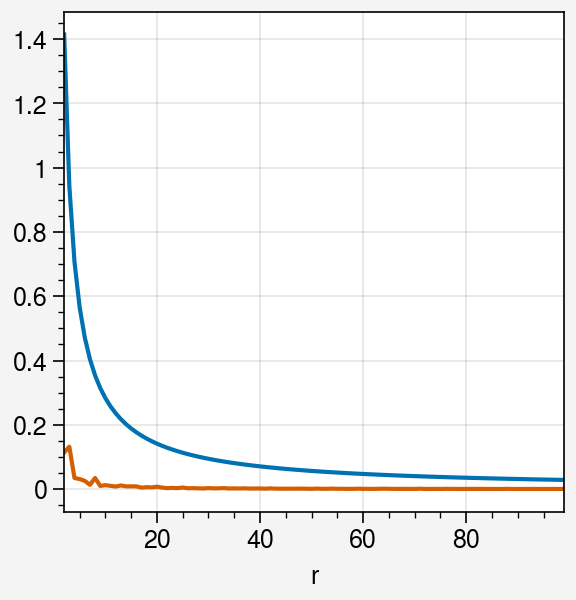

In [227]:
r = np.arange(2, 100)
fig, ax = pplt.subplots()
ax.plot(r, 2 * np.sqrt(2)/r)
ax.plot(ss_med.index, np.abs(ss_p99['area_error']/ss_mean['area_true']))
# ax.axhline(0.1)

In [288]:
r = np.ceil(2*np.sqrt(2)/0.05)
r, np.pi*r**2

(57.0, 10207.034531513238)

In [290]:
np.sqrt(np.pi)*r*0.25

25.2574673754036

12 km floe length scale